In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
from experiments.exp_basic import Exp_Basic
from experiments.exp_long_term_forecasting_partial import Exp_Long_Term_Forecast_Partial
from experiments.exp_long_term_forecasting import Exp_Long_Term_Forecast
from data_provider.data_factory import data_provider
import random
import torch
import sys
import os
from collections import namedtuple

sys.argv = ['']

fix_seed = 2024
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [2]:
from utils.load import parse_bash_script, get_default_config, merge_args

In [3]:
bash_script_file = 'scripts/best_MS.sh'  # Replace with your bash script file name
with open(bash_script_file, 'r') as f:
    script_content = f.read()

bash_args = parse_bash_script(script_content)
bash_args.model_id

'custom_model'

In [4]:
default_args = get_default_config().parse_args()
default_args

Namespace(is_training=1, model_id='Exchange_96_96', model='iTransformer', data='custom', root_path='D:/FPT/SU24/DSP391m/code/crawl/data/clean/', data_path='df_combine.csv', features='S', target='Sell', freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=96, enc_in=7, dec_in=7, c_out=7, d_model=128, n_heads=8, e_layers=2, d_layers=1, d_ff=128, moving_avg=25, factor=1, distil=True, dropout=0.1, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=1, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', loss='MSE', lradj='type1', use_amp=False, use_gpu=False, gpu=0, use_multi_gpu=False, devices='0,1,2,3', exp_name='partial_train', channel_independence=False, inverse=False, class_strategy='projection', target_root_path='D:/FPT/SU24/DSP391m/code/crawl/data/clean/', target_data_path='df_combine.csv', efficient_training=False, use_norm=True, partial_start_index=0)

In [5]:
args = merge_args(bash_args, default_args)
args

Namespace(is_training=1, root_path='D:/FPT/SU24/DSP391m/try/iTransformer/data/real/', data_path='df_combine.csv', model_id='custom_model', model='iTransformer', data='custom', features='MS', target='Sell', freq='d', seq_len=60, pred_len=60, e_layers=1, enc_in=9, dec_in=9, c_out=9, des='Exp', d_model=512, d_ff=512, itr=1, target_root_path='D:/FPT/SU24/DSP391m/try/iTransformer/data/real/', target_data_path='df_combine.csv', lradj='type1', learning_rate=0.0001, patience=5, moving_avg=10, dropout=0.25, train_epochs=20, batch_size=32, checkpoints='./checkpoints/', label_len=48, n_heads=8, d_layers=1, factor=1, distil=True, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, loss='MSE', use_amp=False, use_gpu=False, gpu=0, use_multi_gpu=False, devices='0,1,2,3', exp_name='partial_train', channel_independence=False, inverse=False, class_strategy='projection', efficient_training=False, use_norm=True, partial_start_index=0)

In [6]:
setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.model_id,
            args.model,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.d_model,
            args.n_heads,
            args.e_layers,
            args.d_layers,
            args.d_ff,
            args.factor,
            args.embed,
            args.distil,
            args.des,
            args.class_strategy, 0)
setting

'custom_model_iTransformer_custom_MS_ft60_sl48_ll60_pl512_dm8_nh1_el1_dl512_df1_fctimeF_ebTrue_dtExp_projection_0'

In [7]:
# args.inverse = True
exp = Exp_Long_Term_Forecast(args)
exp.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

Use CPU


<All keys matched successfully>

In [8]:
exp.test(setting)

border1s:  [0, 3348, 3630]
border1:  3630
border2s:  [3408, 3690, 4010]
border2:  4010
test 261
test shape: (261, 1, 60, 1) (261, 1, 60, 1)
[[[[1.6087854]
   [1.5798503]
   [1.5836024]
   ...
   [1.5475606]
   [1.5920814]
   [1.5920094]]]


 [[[1.6298927]
   [1.5885403]
   [1.598806 ]
   ...
   [1.5744323]
   [1.6088297]
   [1.5990204]]]


 [[[1.6434231]
   [1.6116219]
   [1.6416699]
   ...
   [1.606328 ]
   [1.5993098]
   [1.6000983]]]


 ...


 [[[2.7241867]
   [2.7014303]
   [2.6747155]
   ...
   [2.6759152]
   [2.6544275]
   [2.6841016]]]


 [[[2.7281368]
   [2.7020185]
   [2.6871076]
   ...
   [2.6720233]
   [2.6529102]
   [2.66238  ]]]


 [[[2.7195604]
   [2.6886334]
   [2.6841178]
   ...
   [2.6514177]
   [2.629303 ]
   [2.6436665]]]]
[[[[1.5898345]
   [1.6502078]
   [1.8192527]
   ...
   [1.3724909]
   [1.3845656]
   [1.3845656]]]


 [[[1.6502078]
   [1.8192527]
   [1.8192527]
   ...
   [1.3845656]
   [1.3845656]
   [1.3845656]]]


 [[[1.8192527]
   [1.8192527]
   [1.8192527]
 

In [9]:
args.is_training = 0 
exp = Exp_Long_Term_Forecast(args)
exp.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))
exp.predict(setting)

Use CPU
Start index in raw df: 3950
End index in raw df: 4010
pred 1
[[[2.4040752e+04 2.4070752e+04 3.5883103e-02 3.4187790e-02 2.0484859e+01
   6.6421913e+01 2.4410750e+04]
  [2.4067182e+04 2.4097182e+04 3.5886906e-02 3.4196638e-02 2.0487276e+01
   6.6428345e+01 2.4437182e+04]
  [2.4057012e+04 2.4087012e+04 3.5935979e-02 3.4309659e-02 2.0484827e+01
   6.6421814e+01 2.4427012e+04]
  [2.4055814e+04 2.4085814e+04 3.5963830e-02 3.4373898e-02 2.0484074e+01
   6.6419815e+01 2.4425812e+04]
  [2.4060959e+04 2.4090959e+04 3.5784967e-02 3.3961352e-02 2.0497564e+01
   6.6455856e+01 2.4430961e+04]
  [2.4053645e+04 2.4083645e+04 3.5928778e-02 3.4292415e-02 2.0503740e+01
   6.6472328e+01 2.4423645e+04]
  [2.4059949e+04 2.4089949e+04 3.5880670e-02 3.4181908e-02 2.0495932e+01
   6.6451485e+01 2.4429949e+04]
  [2.4061045e+04 2.4091045e+04 3.5869814e-02 3.4156766e-02 2.0496630e+01
   6.6453331e+01 2.4431045e+04]
  [2.4054369e+04 2.4084369e+04 3.5740178e-02 3.3858497e-02 2.0495207e+01
   6.6449539e+01 2

In [19]:
import numpy as np

# Example numpy array (replace this with your actual numpy array)
pred_array = np.array([
    [[24040.752, 24070.752, 0.035883103, 0.03418779, 20.484859, 66.421913, 24410.75],
     [24067.182, 24097.182, 0.035886906, 0.034196638, 20.487276, 66.428345, 24437.182]],
    # Add more inner lists as needed
])

# Get the last item from each inner list
last_items = pred_array[:, :, -1]

print(last_items)

[[24410.75  24437.182]]


In [20]:
mae, mse, rmse, mape, mspe = np.load(os.path.join('results/' + setting, 'metrics.npy'))
preds = np.load(os.path.join('results/' + setting, 'pred.npy'))
trues = np.load(os.path.join('results/' + setting, 'true.npy'))
real_pred_array = np.load(os.path.join('results/' + setting, 'real_prediction.npy'))
train_loss = np.load(os.path.join('results/' + setting, 'train_loss.npy'))
val_loss = np.load(os.path.join('results/' + setting, 'val_loss.npy'))

In [21]:
real_pred = real_pred_array[:, :, -1]
real_pred

array([[24410.75 , 24437.182, 24427.012, 24425.812, 24430.96 , 24423.645,
        24429.95 , 24431.045, 24424.37 , 24421.781, 24419.879, 24441.459,
        24465.2  , 24411.021, 24455.467, 24444.168, 24424.021, 24475.426,
        24411.275, 24421.084, 24399.84 , 24434.6  , 24425.424, 24415.387,
        24403.195, 24439.395, 24433.627, 24415.324, 24425.75 , 24437.316,
        24407.172, 24395.87 , 24366.768, 24405.535, 24395.314, 24424.457,
        24427.766, 24383.38 , 24428.92 , 24411.035, 24413.15 , 24421.125,
        24415.854, 24399.016, 24430.709, 24453.236, 24398.477, 24391.684,
        24463.082, 24405.754, 24404.773, 24426.979, 24402.846, 24435.045,
        24422.734, 24408.65 , 24425.15 , 24395.35 , 24410.13 , 24403.336]],
      dtype=float32)

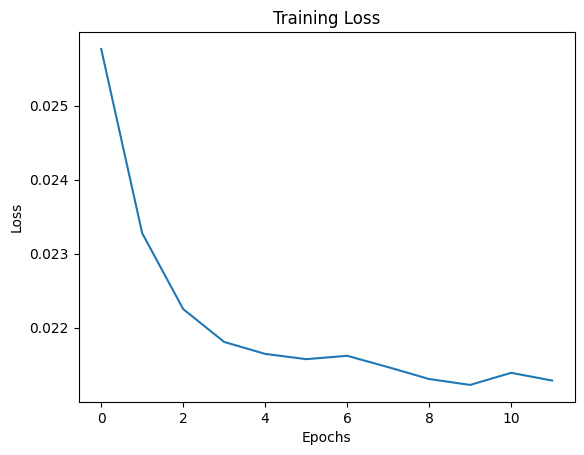

In [15]:
%matplotlib inline
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

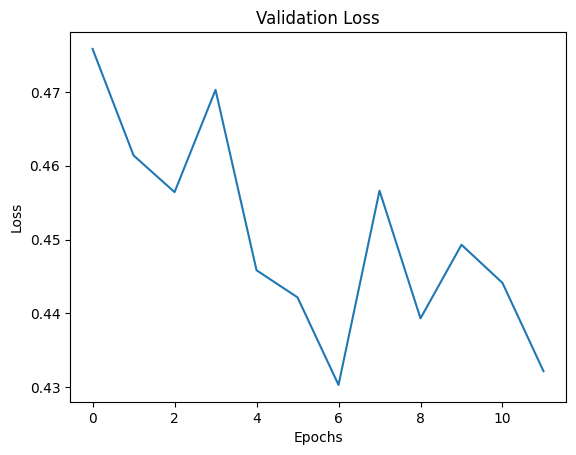

In [16]:
plt.plot(val_loss)
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [26]:
import pandas as pd
df = pd.read_csv('D:/FPT/SU24/DSP391m/code/crawl/data/clean/df_combine.csv')
test_df = df.iloc[3950:]
y_test = test_df.Sell.to_list()
len(y_test)

60

In [23]:
# Flatten the 3D array to 1D and convert to list
pred_flattened = real_pred.flatten().tolist()
len(pred_flattened)

60

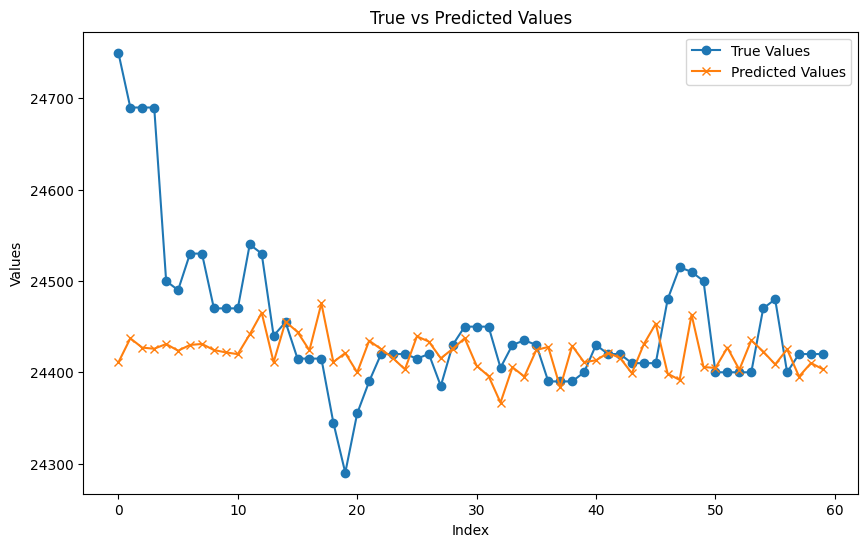

In [27]:
# Ensure y_test and pred_flattened are the same length
assert len(y_test) == len(pred_flattened), "Lengths of y_test and pred do not match!"

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values', marker='o')
plt.plot(pred_flattened, label='Predicted Values', marker='x')
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()